In [1]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img1_col = cv2.imread('almanac.jpg')
img1 = cv2.cvtColor(img1_col, cv2.COLOR_BGR2GRAY)
img1_col = cv2.cvtColor(img1_col, cv2.COLOR_BGR2RGB)

img2_col = cv2.imread('desk.jpg')
img2 = cv2.cvtColor(img2_col, cv2.COLOR_BGR2GRAY)
img2_col = cv2.cvtColor(img2_col, cv2.COLOR_BGR2RGB)


In [3]:
sift = cv2.SIFT_create()

In [4]:
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

In [5]:
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.match(descriptors1, descriptors2)

In [6]:
matches = sorted(matches, key = lambda x:x.distance)

extract the locations of matched keypoints in both the images

In [7]:
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches[:10]]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches[:10]]).reshape(-1, 1, 2)

In [8]:
src_pts

array([[[249.13246, 314.8534 ]],

       [[132.39326, 479.4664 ]],

       [[310.2118 , 438.1864 ]],

       [[258.85074, 243.62747]],

       [[322.61896, 453.59775]],

       [[ 58.00566,  30.89394]],

       [[239.88615, 295.6542 ]],

       [[ 59.53093, 378.10385]],

       [[ 58.00566,  30.89394]],

       [[182.108  , 370.79834]]], dtype=float32)

In [9]:
dst_pts

array([[[1189.8048 ,  985.1509 ]],

       [[1059.1482 , 1016.46765]],

       [[1170.016  , 1067.8458 ]],

       [[1225.176  ,  955.2665 ]],

       [[1170.0183 , 1079.6346 ]],

       [[1204.7816 ,  790.7735 ]],

       [[1193.2627 ,  972.13385]],

       [[1065.5387 ,  942.1366 ]],

       [[1204.7816 ,  790.7735 ]],

       [[1130.3528 ,  984.9893 ]]], dtype=float32)

find the perspective transformation (3x3 transformation matrix)

In [10]:
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

In [11]:
M

array([[ 2.60013539e-01, -4.71524101e-01,  1.18781442e+03],
       [ 1.58471861e-01,  3.65583422e-01,  7.59326735e+02],
       [-2.02502087e-04, -6.80924171e-05,  1.00000000e+00]])

mask for inliers

In [12]:
matchesMask = mask.ravel().tolist()

transform the corners of queryImage to corresponding points in trainImage

In [13]:
h, w = img1.shape
query_corners = np.float32([[0, 0], [0, h-1], [w-1, h-1],[w-1, 0]]).reshape(-1, 1, 2)
transformed_points = cv2.perspectiveTransform(query_corners, M)

In [14]:
transformed_points

array([[[1187.8145 ,  759.3267 ]],

       [[ 942.17065, 1021.7253 ]],

       [[1139.7363 , 1181.8505 ]],

       [[1397.4093 ,  890.0699 ]]], dtype=float32)

show outline of transformed object in green

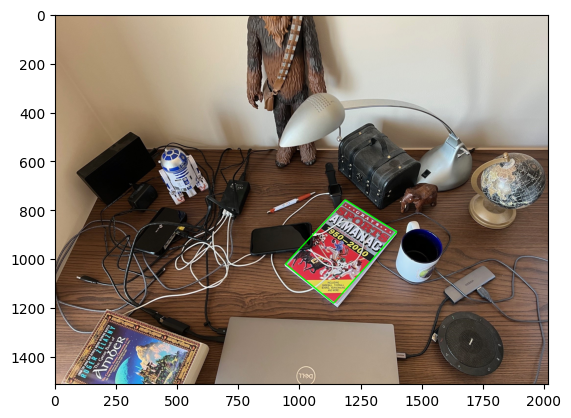

In [15]:
img2_col = cv2.polylines(img2_col, [np.int32(transformed_points)], True, (0, 255, 0), 3, cv2.LINE_AA)
plt.imshow(img2_col)

show together with inlier matches

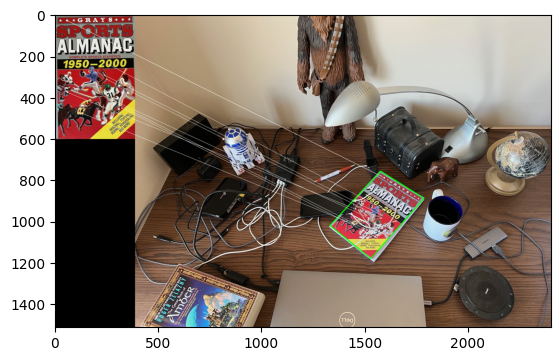

In [16]:
draw_params = dict(matchColor = (255, 255, 255), singlePointColor = None, matchesMask = matchesMask, flags = 2)
image_perspective = cv2.drawMatches(img1_col, keypoints1, img2_col, keypoints2, matches[:10], None, **draw_params)
plt.imshow(image_perspective)

apply homography to full image

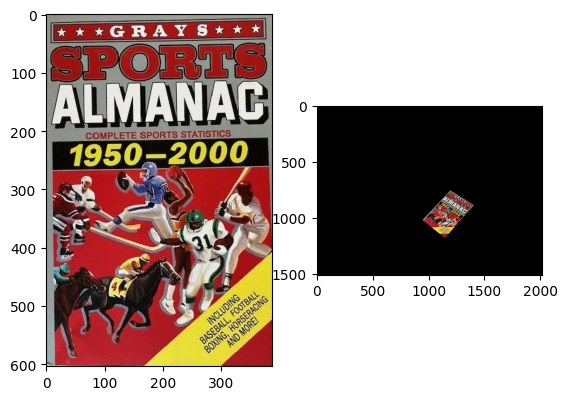

In [17]:
h, w = img2.shape
warped_image = cv2.warpPerspective(img1_col, M, (w, h))

plt.subplot(121)
plt.imshow(img1_col)
plt.subplot(122)
plt.imshow(warped_image)